## Config

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import os
import sys
p = os.path.join(os.path.dirname('__file__'), '..')
sys.path.append(p)
from common import *
from imutils.object_detection import non_max_suppression

from matplotlib import animation, rc
from IPython.display import HTML
from matplotlib.pyplot import Rectangle

In [2]:
DATA_DIR = '../data/'
json_fpath = os.path.join(DATA_DIR, 'volleyball_frame_00665.json')
img_fpath = os.path.join(DATA_DIR, 'volleyball_frame_00665.png')
IMG_DIR = os.path.join(DATA_DIR, 'volleyball', 'images_subset')
metadata_fpath = os.path.join(DATA_DIR, 'volleyball_bbox_labels.csv')
FIGSIZE = (6,6)

## Helpers

In [16]:
def plot_img(arr, fs=FIGSIZE, cmap='gray', title=None):
    plt.figure(figsize=fs)
    plt.imshow(arr, cmap=cmap)
    plt.title(title)
    plt.show()
    
def load_img(fpath):
    return plt.imread(fpath)

def load_cv2_img(fpath, w=None, h=None, colorspace=None):
    img = cv2.imread(fpath)
    if colorspace is not None:
        img = cv2.cvtColor(img, colorspace)
    if None not in [w,h]:
        img = cv2.resize(img, (w, h), interpolation=cv2.INTER_CUBIC)
    return img

def threshold_color(img, color, thresh, sigma=1.0):
    """
    color = [b, g, r] or [r,b,g] or [h,s,v]
    thresh = [b,g,r] margin allowed around color (1 per channel)
    """
    if isinstance(thresh, int):
        thresh = [thresh]*3
    thresh = np.array(thresh) * sigma
    min_color = np.array([color[0]-thresh[0], color[1]-thresh[1], 
                          color[2]-thresh[2]])
    max_color = np.array([color[0]+thresh[0], color[1]+thresh[1],
                          color[2]+thresh[2]])
    min_color[min_color < 0] = 0
    max_color[max_color > 255] = 255
    print("Min", min_color)
    print("Max", max_color)
    
    mask = cv2.inRange(img, min_color, max_color)
    result = cv2.bitwise_and(img, img, mask=mask)
    return mask, result

def get_color_of_pixel(fpath, x, y, colorspace='BGR'):
    rgb_img = load_cv2_img(img_fpath, colorspace=cv2.COLOR_BGR2RGB)
    hsv_img = load_cv2_img(img_fpath, colorspace=cv2.COLOR_BGR2HSV)
    
    rgb_colors = rgb_img[y,x,:]
    hsv_colors = hsv_img[y,x,:]
    bgr_colors = np.copy(rgb_colors[::-1])
    print ("BGR:", bgr_colors)
    print ("RGB:", rgb_colors)
    print ("HSV:", hsv_colors)
    
    # Plot to visualize
    img = np.copy(rgb_img)
    img[y-5:y+5:,x-5:x+5,:] = 255
    img[y,x,:] = 0
    
    if colorspace == 'BGR':
        return bgr_colors.tolist()
    if colorspace == 'RGB':
        return rgb_colors.tolist()
    return hsv_colors.tolist()

def get_hsv_value_of_bgr(bgr_color):
    print("BGR", bgr_color)
    bgr_color = np.uint8([[bgr_color]])
    hsv = cv2.cvtColor(bgr_color, cv2.COLOR_BGR2HSV)[0][0]
    print("HSV", hsv)
    return hsv

# Create color histograms representing average values among samples
def get_flattened_channels(imgs):
    chans = np.empty(shape=(1,3))
    for img in imgs:
        h,w,c = img.shape
        reshaped = img.reshape((h*w, c))
        chans = np.concatenate([chans, reshaped], axis=0)
        #print(reshaped.shape, chans.shape)
    return chans

def get_color_hist(img, bins, mask):
    hists = {}
    color = ('r','g','b')
    for i,col in enumerate(color):
        histr = cv2.calcHist([img],[i],mask,[bins],[0,256])
        hists[col] = histr
    return hists

# Plotting Histogram (all channels flattened)
def plot_hist(img, bins=256, title=None):
    plt.hist(img.ravel(), bins=bins, range=[0,256])
    plt.title(title)
    plt.show()

def plot_bgr_hist(bgr_img, bins=256, mask=None):
    # Mask let's you select for certain regions    
    color = ('b','g','r')
    for i,col in enumerate(color):
        histr = cv2.calcHist([bgr_img],[i],mask,[bins],[0,256])
        plt.plot(histr, color=col)
        plt.xlim([0,bins])
    plt.show()

def plot_hists_dict(hists):
    for col,hist in hists.items():
        plt.plot(hist, color=col)
    plt.show()
    
def plot_bbs_from_rectLabel_annos(json_fpath, img_fpath):
    bb_json = json.load(open(json_fpath, 'r'))
    fig = plt.figure(figsize=FIGSIZE)
    axes = plt.axes([0, 0.03, 1, 0.97])
    
    img = plt.imread(img_fpath)
    imgplot = axes.imshow(img)

    for box in bb_json['objects']:
        label = box['label']
        color = BOX_COLORS[label]
        coords = box['x_y_w_h']
        bb = Rectangle(
            (coords[0],coords[1]), 
            coords[2], coords[3],
            fill=False,
            edgecolor=color,
            linewidth=2)
        axes.add_patch(bb)
        
def get_img_crops_from_rectLabel_bbs(img, json_fpath):
    crops_dict = {}
    bb_json = json.load(open(json_fpath, 'r'))
    for box in bb_json['objects']:
        label = box['label']
        x,y,w,h = box['x_y_w_h']
        crop = img[y:y+h,x:x+w,:]
        if label not in crops_dict:
            crops_dict[label] = []
        crops_dict[label].append(crop)
    return crops_dict

def make_boxes(meta):
    boxes = {}
    for idx,row in meta.iterrows():
        box = json.loads(row.to_json())
        fname = row['filename']
        if fname in boxes:
            boxes[fname].append(box)
        else:
            boxes[fname] = [box]
    return boxes

def median_filter(mask, ksize=3, thresh=25):
    median = cv2.medianBlur(mask, ksize)
    return median

def opening(img, ksize=(3,3)):
    # Erode --> Dilate
    erode_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, ksize)
    dilate_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, ksize)
    img = cv2.erode(img, erode_kernel, iterations = 1)
    img = cv2.dilate(img, dilate_kernel, iterations = 1)
    return img

def closing(img, ksize=(3,3)):
    # Dilate --> Erode
    erode_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, ksize)
    dilate_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, ksize)
    img = cv2.dilate(img, dilate_kernel, iterations = 1)
    img = cv2.erode(img, erode_kernel, iterations = 1)
    return img

def apply_bg_mask(fpaths, subtractor, limit=100, cleanup=None):
    i = 0
    masks = []
    for fpath in fpaths:
        img = load_cv2_img(fpath, colorspace=cv2.COLOR_BGR2RGB)
        fgmask = subtractor.apply(img)
        if cleanup == 'open':
            fgmask = opening(fgmask)
        elif cleanup == 'close':
            fgmask = closing(fgmask)
        elif cleanup == 'median':
            fgmask = median_filter(fgmask)
        fgmask[fgmask >= 2] = 255
        fgmask[fgmask < 2] = 0
        masks.append(fgmask)
        if i > limit:
            break
        i+=1
    return masks

def get_masked_imgs(fpaths, masks):
    imgs = []
    for fpath, mask in zip(fpaths, masks):
        img = load_cv2_img(fpath, colorspace=cv2.COLOR_BGR2RGB)
        img[mask == 0] = 255
        imgs.append(img)
    return imgs

def get_img_crop(img, x1, y1, x2, y2):
    if len(img.shape) > 2:
        return img[y1:y2,x1:x2,:]
    return img[y1:y2,x1:x2]

def plot_boxes(img, rects, title="boxes", color=(255,255,255), thick=2):
    for (x1, y1, x2, y2) in rects:
        cv2.rectangle(img, (x1, y1), (x2, y2), color, thick)
    plot_img(img, title=title)

In [4]:
metadata = pd.read_csv(metadata_fpath)
metadata['label_name'] = 'ball'
metadata['label_id'] = 1
fnames = metadata['filename']
fpaths = [os.path.join(IMG_DIR, f) for f in fnames]
metadata['fpath'] = fpaths
GT_BOXES = make_boxes(metadata)

## Background Subtraction

* https://pdfs.semanticscholar.org/8a1f/27fd371eceb8654b735502b810d2094e420b.pdf
* http://airccj.org/CSCP/vol7/csit76313.pdf
* http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.131.3661&rep=rep1&type=pdf
* https://www.sciencedirect.com/science/article/pii/S2213020916300866
* https://github.com/ITCoders/Human-detection-and-Tracking/blob/master/main.py
* https://github.com/OpenPTrack/open_ptrack

### Background Model

In [5]:
## KNN Subtraction seems to work better
def segment_knn(fpaths, subtractor, kernel, plot_mask=True):
    i = 0
    for fpath in fpaths:
        img = load_cv2_img(fpath, colorspace=cv2.COLOR_BGR2RGB)
        fgmask = subtractor.apply(img)
        #fgmask = cv2.morphologyEx(fgmask, cv2.MORPH_OPEN, kernel)
        if plot_mask and i > 0 and i % 500 == 0:
            plot_img(fgmask, fs=FIGSIZE, title=fpath)    
        i+=1
    return subtractor.getBackgroundImage()

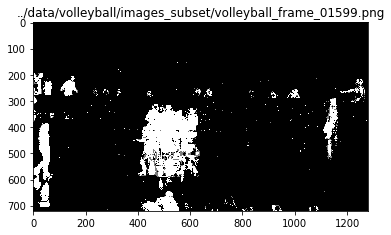

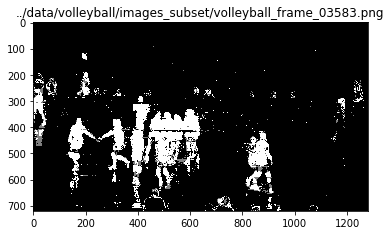

In [6]:
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3))
knn_subtractor = cv2.createBackgroundSubtractorKNN()
bg_img = segment_knn(metadata['fpath'], knn_subtractor, kernel, plot_mask=True)

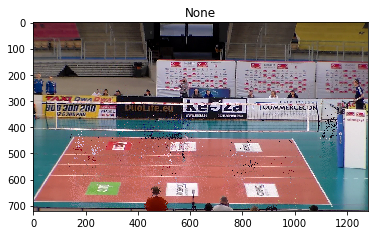

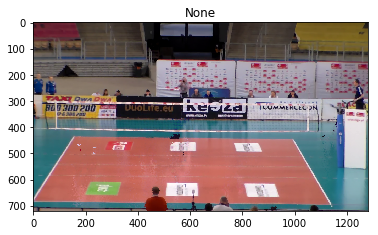

In [7]:
# Median Filter
# Clears out the Salt and pepper noise
# https://docs.opencv.org/3.1.0/d4/d13/tutorial_py_filtering.html
plot_img(bg_img, fs=FIGSIZE)
median = cv2.medianBlur(bg_img, 5)
plot_img(median, fs=FIGSIZE)

### Extract Masks

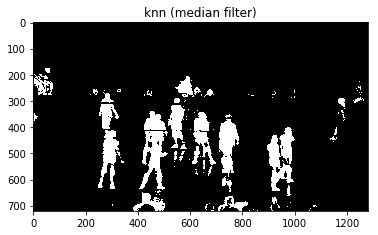

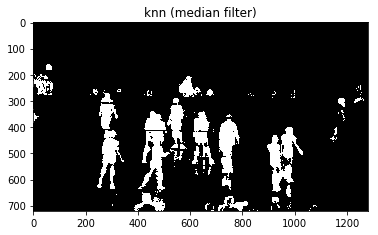

In [8]:
# Binary Mask
plot_limit = 2
binary_masks = apply_bg_mask(metadata['fpath'], knn_subtractor, limit=10, cleanup='median')
for m in binary_masks[:plot_limit]:
    plot_img(m, title='knn (median filter)')

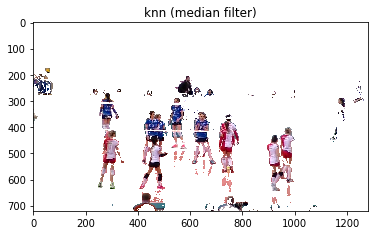

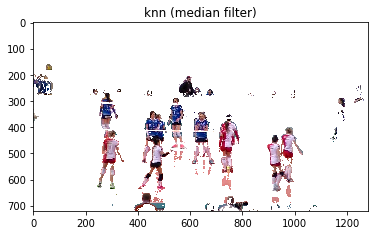

In [9]:
# Color Masks
color_masks = get_masked_imgs(metadata['fpath'], binary_masks)
for m in color_masks[:plot_limit]:
    plot_img(m, title='knn (median filter)')

### Mask Cleanup

In [10]:
def cleanup_mask(mask, cleanup_type):
    if cleanup_type == 'median':
        return cv2.medianBlur(mask, ksize=9)
    elif cleanup_type == 'gaussian':
        return cv2.GaussianBlur(mask, ksize=(9,9), sigmaX=2)
    elif cleanup_type == 'open':
        return opening(mask, ksize=(7,7))
    elif cleanup_type == 'close':
        return opening(mask, ksize=(5,5))
    else:
        raise Exception("Cleanup type not found")
        
def clean_masks(masks, cleanup_type):
    for i,mask in enumerate(masks):
        masks[i] = cleanup_mask(mask, cleanup_type)
    return masks

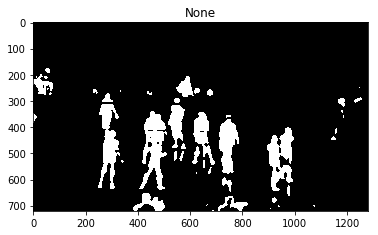

In [11]:
clean_mask = cleanup_mask(binary_masks[0], 'median')
plot_img(clean_mask)

## Find Contours


* https://docs.opencv.org/3.2.0/d0/d49/tutorial_moments.html
* http://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_contours/py_contour_properties/py_contour_properties.html

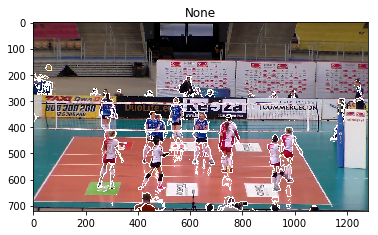

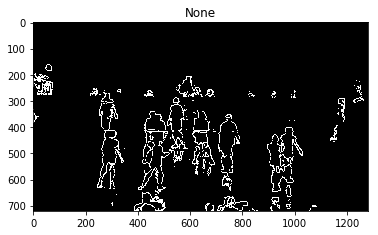

In [12]:
def get_contours(binary_mask):
    image, contours, hierarchy = cv2.findContours(binary_mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    return contours

def plot_contours(img, contours, color=(255,255,255), thick=2):
    img = img.copy()
    img = cv2.drawContours(img, contours, -1, color, thickness=thick)
    plot_img(img)

idx = 1
img = load_cv2_img(metadata['fpath'][idx], colorspace=cv2.COLOR_BGR2RGB)
bm = binary_masks[idx].copy()
cm = color_masks[idx].copy()
contours = get_contours(bm)
plot_contours(img, contours)
plot_contours(bm, contours)

### Filter Contours By Aspect Ratio and Area

In [13]:
def filter_contours(contours, binary_mask, color_mask):
    cntrs = []
    bbs = []
    color_means = []
    color_hists = []
    for cnt in contours:
        valid = True
        x,y,w,h = cv2.boundingRect(cnt)
        aspect_ratio = float(w)/h

        # Let's store color information
        mask = np.zeros(binary_mask.shape, np.uint8)
        cv2.drawContours(mask, [cnt], 0, 255, -1)
        mean_color = None#cv2.mean(color_mask, mask = mask)
        hist = None#get_color_hist(color_mask, bins=256, mask=mask)

        # We assume the height needs to be > width
        if aspect_ratio > .8 or aspect_ratio < .1:
            valid = False

        # We assume the box area needs to be > 5000 pixels 
        # Eyeballing suggests players are around 200x100 = 20000 pixels
        area = w*h
        if area < 4000:
            valid = False
        if valid:
            #print("Aspect Ratio (W/H):", aspect_ratio, "Area", w*h)
            bbs.append((x,y,x+w,y+h))
            cntrs.append(cnt)
            color_means.append(mean_color)
            color_hists.append(hist)
    return cntrs, bbs, color_hists


bm = binary_masks[idx].copy()
cm = color_masks[idx].copy()
cntrs, bbs, color_hists = filter_contours(contours, bm, cm)

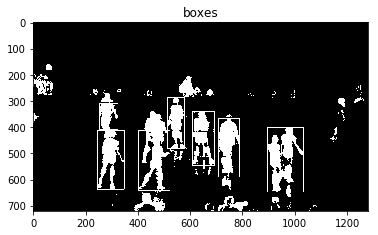

In [17]:
plot_boxes(bm, bbs, color=(255,255,255), thick=2)

### Image Moments (centroid)

* https://en.wikipedia.org/wiki/Image_moment
* https://docs.opencv.org/3.1.0/dd/d49/tutorial_py_contour_features.html

In [ ]:
def get_moments(contours):
    moments = []
    for c in cntrs:
        M = cv2.moments(c)
        moments.append(M)
    return moments

def plot_moments(color_mask, moments):
    color_mask = color_mask.copy()
    for M in moments:
        cX = int(M["m10"] / M["m00"])
        cY = int(M["m01"] / M["m00"])
        cv2.circle(color_mask, (cX, cY), 7, (0, 255, 0), -1)
    plot_img(color_mask)
    
moments = get_moments(contours)
plot_moments(cm, moments)

## Track Players

In [18]:
def train_subtractor(fpaths):
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3))
    knn_subtractor = cv2.createBackgroundSubtractorKNN()
    bg_img = segment_knn(metadata['fpath'], knn_subtractor, kernel, plot_mask=False)
    return bg_img, knn_subtractor

In [ ]:
img_fpaths = metadata['fpath']
bg_img, subtractor = train_subtractor(fpaths)
binary_masks = apply_bg_mask(img_fpaths, subtractor, limit=10000, cleanup='median')
color_masks = get_masked_imgs(img_fpaths, binary_masks)
len(binary_masks), len(color_masks)

In [ ]:
binary_masks = clean_masks(binary_masks, 'median')
color_masks = clean_masks(color_masks, 'median')

In [ ]:
all_contours = []
all_bbs = []
for fpath, bm, cm in zip(fpaths, binary_masks, color_masks):
    ctrs = get_contours(bm)
    ctrs, bbs, color_hists = filter_contours(ctrs, bm, cm)
    all_contours.append(ctrs)
    all_bbs.append(bbs)

In [ ]:
def get_tracked_imgs(fpaths, binary_masks, color_masks, all_bbs):
    imgs = []
    for fpath, bm, cm, bbs in zip(fpaths, binary_masks, color_masks, all_bbs):
        img = load_cv2_img(fpath, colorspace=cv2.COLOR_BGR2RGB)
        for (x1, y1, x2, y2) in bbs:
            cv2.rectangle(img, (x1, y1), (x2, y2), (0,255,0), thickness=2)
        imgs.append(img)
    return imgs

In [ ]:
tracked_imgs = get_tracked_imgs(fpaths, binary_masks, color_masks, all_bbs)

## Animation

In [ ]:
fig = plt.figure()
axes = plt.axes([0, 0.03, 1, 0.97])
img = tracked_imgs[0]
imgplot = axes.imshow(img, animated=True)
def init():
    return (imgplot,)

def animate(img):
    imgplot.set_array(img)
    return (imgplot,)

anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=tracked_imgs, interval=30, blit=True)

In [ ]:
# ~1 minute to generate
HTML(anim.to_html5_video())

## Links

* https://docs.opencv.org/2.4/modules/objdetect/doc/latent_svm.html
* https://www.pyimagesearch.com/2014/11/17/non-maximum-suppression-object-detection-python
* https://www.pyimagesearch.com/2015/11/16/hog-detectmultiscale-parameters-explained/
* http://lear.inrialpes.fr/people/triggs/pubs/Dalal-cvpr05.pdf
* http://mccormickml.com/2013/05/09/hog-person-detector-tutorial/
* https://www.learnopencv.com/histogram-of-oriented-gradients/
* https://stackoverflow.com/questions/34985196/opencv-using-svm-and-hog-for-person-detection
* https://www.pyimagesearch.com/2015/11/09/pedestrian-detection-opencv/

## Haar Cascade Classifier (EXTRA)

* http://www.bogotobogo.com/python/OpenCV_Python/python_opencv3_Image_Object_Detection_Face_Detection_Haar_Cascade_Classifiers.php
* http://coding-robin.de/2013/07/22/train-your-own-opencv-haar-classifier.html
* https://apparatusd.wordpress.com/2012/02/07/human-target-in-less-than-90-lines-of-code-pythonopencv/

In [ ]:
fullbody_cascade = cv2.CascadeClassifier(str(Path(DATA_DIR, 'haarcascade_fullbody.xml')))
fullbody_cascade.getOriginalWindowSize()
img = load_cv2_img(img_fpath, colorspace=cv2.COLOR_BGR2GRAY)
img = imutils.resize(img, width=min(1000, img.shape[1]))
body_rect = fullbody_cascade.detectMultiScale(img, scaleFactor=1.01, minNeighbors=4) 
plot_boxes(img, body_rect, title="boxes", fs=FIGSIZE)
# Lol